# GAN tutorial with MNIST
original source: [golbin's github](https://github.com/golbin/TensorFlow-Tutorials/blob/master/07%20-%20GAN/02%20-%20GAN2.py)

위 원본 코드를 약간의 주석을 추가하여 jupyter-notebook으로 옮겼습니다.

In [17]:
# GAN 모델을 이용해 단순히 랜덤한 숫자를 생성하는 아닌,
# 원하는 손글씨 숫자를 생성하는 모델을 만들어봅니다.
import tensorflow as tf
import matplotlib.pylab as plt
import seaborn
import numpy as np

In [2]:
# tensorflow에서  제공하는 mnist 데이터 로딩
from tensorflow.examples.tutorials.mnist import input_data
# one_hot=True -> label이 one-hot encoding됨
mnist = input_data.read_data_sets("./mnist/data/", one_hot=True) 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting ./mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting ./mnist/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ./mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ./mnist/data/t10k-labels-idx1-ubyte.gz


## Parameter setting

In [3]:
n_hidden = 256  # 히든 레이어의 뉴런 갯수
n_input = 28 * 28  # 입력 크기: 28 * 28 크기의 이미지를 1차원 벡터로 입력

n_noise = 128  # 생성기의 입력으로 들어갈 노이즈의 크기
n_class = 10  # 레이블 갯수 0부터 9까지 총 10개

## Model

In [4]:
X = tf.placeholder(dtype=tf.float32, shape=[None, n_input])  # 이미지 입력
Y = tf.placeholder(dtype=tf.float32, shape=[None, n_class])  # 0~9까지 이미지에 해당하는 레이블 입력
Z = tf.placeholder(dtype=tf.float32, shape=[None, n_noise])  # 노이즈 입력

In [5]:
def generator(noise, labels):
    with tf.variable_scope('generator'):
        # noise 값에 labels 정보를 추가합니다.
        inputs = tf.concat([noise, labels], 1)
        
        # TensorFlow 에서 제공하는 유틸리티 함수를 이용해 신경망을 매우 간단하게 구성할 수 있습니다.
        hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.relu)
        output = tf.layers.dense(hidden, n_input, activation=tf.nn.sigmoid)

    return output

In [6]:
def discriminator(inputs, labels, reuse=None):
    with tf.variable_scope('discriminator') as scope:
        # 노이즈에서 생성한 이미지와 실제 이미지를 판별하는 모델의 변수를 동일하게 하기 위해,
        # 이전에 사용되었던 변수를 재사용하도록 합니다.
        if reuse:
            scope.reuse_variables()

        inputs = tf.concat([inputs, labels], 1)

        hidden = tf.layers.dense(inputs, n_hidden, activation=tf.nn.relu)
        output = tf.layers.dense(hidden, 1, activation=None)

    return output

In [7]:
G = generator(Z, Y)
D_real = discriminator(X, Y)
D_gene = discriminator(G, Y, True)

In [8]:
# 손실함수는 다음을 참고하여 GAN 논문에 나온 방식과는 약간 다르게 작성하였습니다.
# http://bamos.github.io/2016/08/09/deep-completion/

# 진짜 이미지를 판별하는 D_real 값은 1에 가깝도록,
# 가짜 이미지를 판별하는 D_gene 값은 0에 가깝도록 하는 손실 함수입니다.
loss_D_real = tf.reduce_mean( 
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=D_real, labels=tf.ones_like(D_real)))
loss_D_gene = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=D_gene, labels=tf.zeros_like(D_gene)))
# loss_D_real 과 loss_D_gene 을 더한 뒤 이 값을 최소화 하도록 최적화합니다.
loss_D = loss_D_real + loss_D_gene

# 가짜 이미지를 진짜에 가깝게 만들도록 생성망을 학습시키기 위해, D_gene 을 최대한 1에 가깝도록 만드는 손실함수입니다.
loss_G = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(
                    logits=D_gene, labels=tf.ones_like(D_gene)))


In [9]:
# TensorFlow 에서 제공하는 유틸리티 함수를 이용해
# discriminator 와 generator scope 에서 사용된 변수들을 쉽게 가져올 수 있습니다.
vars_D = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
vars_G = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

# 학습시에 var_list에 명시한 변수들만 조정하게됨
# AdamOptimizer에 parameter로 learning_rate를 주지 않으면 기본값 0.001로 학습
train_D = tf.train.AdamOptimizer().minimize(loss_D, var_list=vars_D)
train_G = tf.train.AdamOptimizer().minimize(loss_G, var_list=vars_G)

In [10]:
# noise generate function
def get_noise(batch_size, n_noise):
    return np.random.uniform(-1., 1., size=[batch_size, n_noise])

## Training

In [13]:
total_epoch = 100  # 학습할 epoch 횟수
batch_size = 100  # 배치 크기

Epoch: 0000 D loss: 0.006728 G loss: 7.93


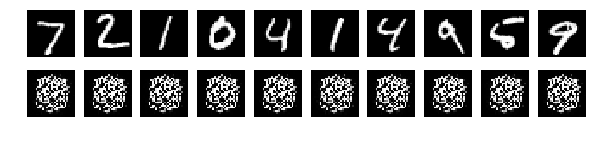

Epoch: 0001 D loss: 0.008138 G loss: 6.797
Epoch: 0002 D loss: 0.00256 G loss: 9.699
Epoch: 0003 D loss: 0.001656 G loss: 10.28
Epoch: 0004 D loss: 0.01677 G loss: 7.9
Epoch: 0005 D loss: 0.009202 G loss: 9.355
Epoch: 0006 D loss: 0.00578 G loss: 10.24
Epoch: 0007 D loss: 0.01995 G loss: 9.406
Epoch: 0008 D loss: 0.00949 G loss: 8.861
Epoch: 0009 D loss: 0.02634 G loss: 8.269


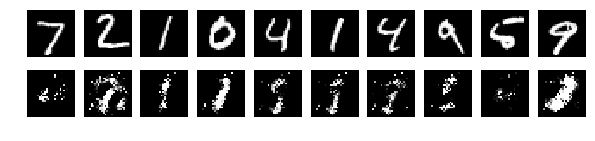

Epoch: 0010 D loss: 0.02239 G loss: 7.887
Epoch: 0011 D loss: 0.1732 G loss: 6.655
Epoch: 0012 D loss: 0.1229 G loss: 5.827
Epoch: 0013 D loss: 0.2592 G loss: 4.661
Epoch: 0014 D loss: 0.2287 G loss: 6.214
Epoch: 0015 D loss: 0.3728 G loss: 4.207
Epoch: 0016 D loss: 0.4212 G loss: 4.355
Epoch: 0017 D loss: 0.4509 G loss: 3.932
Epoch: 0018 D loss: 0.5382 G loss: 3.993
Epoch: 0019 D loss: 0.5597 G loss: 3.243


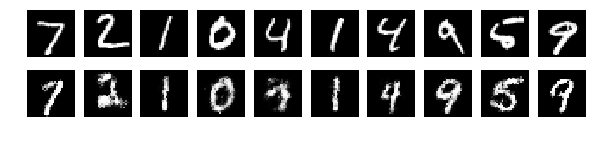

Epoch: 0020 D loss: 0.3926 G loss: 4.169
Epoch: 0021 D loss: 0.7475 G loss: 3.44
Epoch: 0022 D loss: 0.9184 G loss: 2.701
Epoch: 0023 D loss: 0.5318 G loss: 3.358
Epoch: 0024 D loss: 0.5902 G loss: 3.196
Epoch: 0025 D loss: 0.4619 G loss: 3.316
Epoch: 0026 D loss: 0.6475 G loss: 2.599
Epoch: 0027 D loss: 0.7503 G loss: 2.354
Epoch: 0028 D loss: 0.6966 G loss: 2.675
Epoch: 0029 D loss: 0.5026 G loss: 2.766


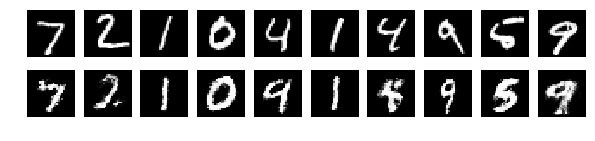

Epoch: 0030 D loss: 0.7978 G loss: 2.492
Epoch: 0031 D loss: 0.6851 G loss: 1.861
Epoch: 0032 D loss: 0.731 G loss: 2.184
Epoch: 0033 D loss: 0.8226 G loss: 2.389
Epoch: 0034 D loss: 0.6892 G loss: 2.667
Epoch: 0035 D loss: 0.6437 G loss: 2.227
Epoch: 0036 D loss: 0.6493 G loss: 2.466
Epoch: 0037 D loss: 0.7461 G loss: 2.501
Epoch: 0038 D loss: 0.7231 G loss: 2.137
Epoch: 0039 D loss: 0.6719 G loss: 2.247


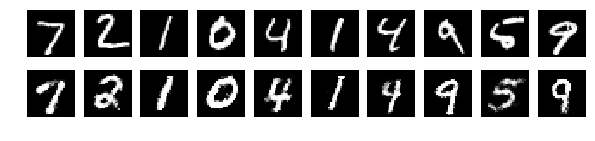

Epoch: 0040 D loss: 1.014 G loss: 1.882
Epoch: 0041 D loss: 0.749 G loss: 2.38
Epoch: 0042 D loss: 0.5847 G loss: 2.003
Epoch: 0043 D loss: 0.7264 G loss: 2.239
Epoch: 0044 D loss: 0.7322 G loss: 2.209
Epoch: 0045 D loss: 0.6713 G loss: 2.34
Epoch: 0046 D loss: 0.8012 G loss: 2.157
Epoch: 0047 D loss: 0.7382 G loss: 2.279
Epoch: 0048 D loss: 0.6599 G loss: 2.291
Epoch: 0049 D loss: 0.7053 G loss: 2.267


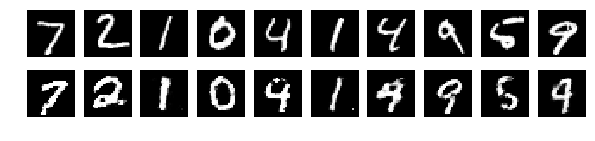

Epoch: 0050 D loss: 0.7293 G loss: 2.005
Epoch: 0051 D loss: 0.8172 G loss: 1.951
Epoch: 0052 D loss: 0.65 G loss: 1.988
Epoch: 0053 D loss: 0.7522 G loss: 1.867
Epoch: 0054 D loss: 0.7375 G loss: 2.5
Epoch: 0055 D loss: 0.9195 G loss: 2.329
Epoch: 0056 D loss: 0.6549 G loss: 2.06
Epoch: 0057 D loss: 0.8084 G loss: 1.875
Epoch: 0058 D loss: 0.6215 G loss: 2.186
Epoch: 0059 D loss: 0.7795 G loss: 2.279


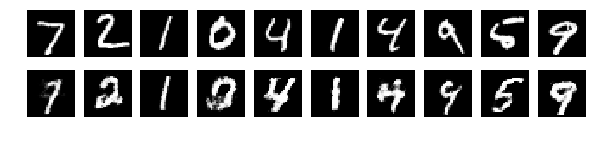

Epoch: 0060 D loss: 0.848 G loss: 2.196
Epoch: 0061 D loss: 0.723 G loss: 2.129
Epoch: 0062 D loss: 0.7902 G loss: 2.31
Epoch: 0063 D loss: 0.7582 G loss: 1.762
Epoch: 0064 D loss: 0.6816 G loss: 2.06
Epoch: 0065 D loss: 0.7178 G loss: 2.29
Epoch: 0066 D loss: 0.611 G loss: 1.956
Epoch: 0067 D loss: 0.8366 G loss: 2.04
Epoch: 0068 D loss: 0.666 G loss: 1.93
Epoch: 0069 D loss: 0.6494 G loss: 2.528


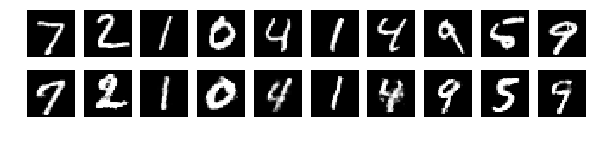

Epoch: 0070 D loss: 0.7307 G loss: 2.126
Epoch: 0071 D loss: 0.7873 G loss: 1.983
Epoch: 0072 D loss: 0.6606 G loss: 1.927
Epoch: 0073 D loss: 0.778 G loss: 1.832
Epoch: 0074 D loss: 0.5984 G loss: 2.367
Epoch: 0075 D loss: 0.6107 G loss: 2.335
Epoch: 0076 D loss: 0.7402 G loss: 2.176
Epoch: 0077 D loss: 0.6839 G loss: 2.155
Epoch: 0078 D loss: 0.6966 G loss: 2.193
Epoch: 0079 D loss: 0.7649 G loss: 2.196


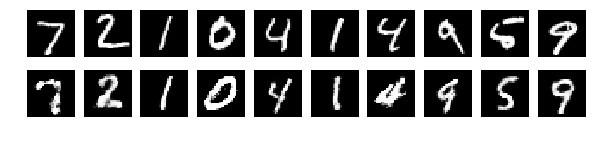

Epoch: 0080 D loss: 0.8109 G loss: 2.397
Epoch: 0081 D loss: 0.6682 G loss: 2.314
Epoch: 0082 D loss: 0.8165 G loss: 2.201
Epoch: 0083 D loss: 0.7903 G loss: 2.076
Epoch: 0084 D loss: 0.8357 G loss: 1.845
Epoch: 0085 D loss: 0.8262 G loss: 1.868
Epoch: 0086 D loss: 0.7191 G loss: 2.052
Epoch: 0087 D loss: 0.8963 G loss: 1.614
Epoch: 0088 D loss: 0.6278 G loss: 1.966
Epoch: 0089 D loss: 0.7365 G loss: 2.503


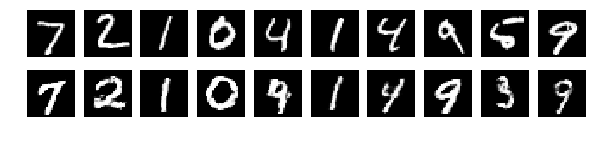

Epoch: 0090 D loss: 0.8529 G loss: 1.967
Epoch: 0091 D loss: 0.7148 G loss: 2.173
Epoch: 0092 D loss: 0.7654 G loss: 2.226
Epoch: 0093 D loss: 0.9392 G loss: 1.996
Epoch: 0094 D loss: 0.8538 G loss: 1.834
Epoch: 0095 D loss: 0.658 G loss: 2.184
Epoch: 0096 D loss: 0.7369 G loss: 1.925
Epoch: 0097 D loss: 0.8446 G loss: 1.69
Epoch: 0098 D loss: 0.8628 G loss: 1.92
Epoch: 0099 D loss: 0.6356 G loss: 2.047


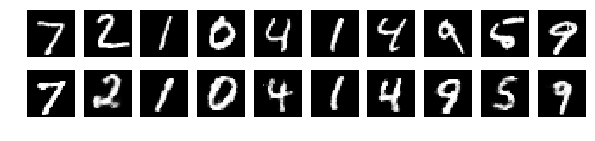

In [21]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

total_batch = int(mnist.train.num_examples/batch_size)
loss_val_D, loss_val_G = 0, 0

for epoch in range(total_epoch):
    for i in range(total_batch):
        batch_xs, batch_ys = mnist.train.next_batch(batch_size)
        noise = get_noise(batch_size, n_noise)

        _, loss_val_D = sess.run([train_D, loss_D],
                                 feed_dict={X: batch_xs, Y: batch_ys, Z: noise})
        _, loss_val_G = sess.run([train_G, loss_G],
                                 feed_dict={Y: batch_ys, Z: noise})

    print('Epoch:', '%04d' % epoch,
          'D loss: {:.4}'.format(loss_val_D),
          'G loss: {:.4}'.format(loss_val_G))

    #########
    # 학습이 되어가는 모습을 보기 위해 주기적으로 레이블에 따른 이미지를 생성하여 저장
    ######
    if epoch == 0 or (epoch + 1) % 10 == 0:
        sample_size = 10
        noise = get_noise(sample_size, n_noise)
        samples = sess.run(G,
                           feed_dict={Y: mnist.test.labels[:sample_size],
                                      Z: noise})

        fig, ax = plt.subplots(2, sample_size, figsize=(sample_size, 2))

        for i in range(sample_size):
            ax[0][i].set_axis_off()
            ax[1][i].set_axis_off()

            ax[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)), cmap='gray')
            ax[1][i].imshow(np.reshape(samples[i], (28, 28)), cmap='gray')
        
        plt.show()